In [1]:
pip install scikit-learn

In [2]:
# Library imports.
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB # ?
from sklearn.naive_bayes import MultinomialNB # ?
from sklearn.model_selection import train_test_split

In [3]:
# Dataset from Kaggle.
# https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health?resource=download

In [4]:
# For reading a "local" CSV using Google Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset = pd.read_csv("/content/drive/MyDrive/Final Project/dataset/Combined_Data.csv") # keep an eye on whitespace?
dataset.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
dataset.describe()

,Unnamed: 0
count,53043.000000
mean,26521.000000
std,15312.339501
min,0.000000
25%,13260.500000
50%,26521.000000
75%,39781.500000
max,53042.000000


In [7]:
# Make a safe copy of the CSV data for cleaning and processing later.
dataset_clean = dataset.copy()
dataset_clean.dropna(inplace = True)
# dataset_clean

In [8]:
dataset_clean.describe()

,Unnamed: 0
count,52681.000000
mean,26365.706042
std,15235.065306
min,0.000000
25%,13180.000000
50%,26350.000000
75%,39522.000000
max,53042.000000


In [9]:
# # preparing to add stemming
import nltk
from nltk.stem import PorterStemmer

nltk.download('punkt') # move up top later
nltk.download('punkt_tab') # need?

# Using Porter stemmer algorithm, fairly straightforward, geared to English (not Lancaster or Snowball)
stemmer = PorterStemmer()

# think about just combining this with the clean_statements function below
# keep an eye on the performance cost on this one, since we're tokenizing then going back to a string (and tokenizing is done again later, monitor necessity of this)
# should work for both the Naive Bayes and the RNN (and the DummyClassifier for the common sense baseline)
def stemming(statement_text):
  # Tokenize each word in the statement for now, preparing for stemming
  word_tokens = nltk.word_tokenize(statement_text)
  # Perform stemming on each word now that they're separated
  post_stemming = [stemmer.stem(word) for word in word_tokens]
  # Going back to a string for further working
  return " ".join(post_stemming)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [10]:
# trying this to get the noisy characters like emojis out
import re # need?

def clean_statements(statement_text): # clean this up later
    # Remove punctuation, special characters, any remaining non-letter characters (?) and extra whitespace
    # statement_text = re.sub(r'[^a-zA-Z0-9\s]', '', statement_text)
    statement_text = re.sub(r'[^a-zA-Z\s]', '', statement_text)
    statement_text = re.sub(r'\s+', ' ', statement_text) # remove extra whitespace

    # Convert everything to lowercase and remove extra whitespace (?) (redundant with regex above? check)
    statement_text = statement_text.lower().strip() # need?
    return statement_text



In [11]:
# Example usage:
# noisy_text = dataset_clean["statement"][3527]
noisy_text = dataset_clean["statement"][352]

clean_text_result = clean_statements(noisy_text)

# print(dataset_clean["statement"][3527])
print("Before and after comparison of a cleaned statement:")
print(dataset_clean["statement"][352])
print(clean_text_result)

Before and after comparison of a cleaned statement:
Usually every night when you're alone you're restless, it's calm. It feels so different.
usually every night when youre alone youre restless its calm it feels so different


In [12]:
# Take our cleaning function and apply it to all of the social media statements.
# Then temporarily make a new column for the cleaned statement for easier viewing.
dataset_clean['processed_statement'] = dataset_clean['statement'].apply(clean_statements)
dataset_clean.head()

,Unnamed: 0,statement,status,processed_statement
0,0,oh my gosh,Anxiety,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shifted my focus to something else but im ...
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless its been a month now ...


In [13]:
# Apply our stemming function to our cleaned statements.
dataset_clean['processed_statement'] = dataset_clean['processed_statement'].apply(stemming)
dataset_clean.head()

,Unnamed: 0,statement,status,processed_statement
0,0,oh my gosh,Anxiety,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,troubl sleep confus mind restless heart all ou...
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shift my focu to someth els but im still w...
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless it been a month now b...


In [14]:
print("Before and after comparison of a cleaned statement after stemming:")
print(dataset_clean["statement"][352])
print(dataset_clean["processed_statement"][352])

Before and after comparison of a cleaned statement after stemming:
Usually every night when you're alone you're restless, it's calm. It feels so different.
usual everi night when your alon your restless it calm it feel so differ


In [15]:
# Let's see all the unique statuses.
dataset_clean["status"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

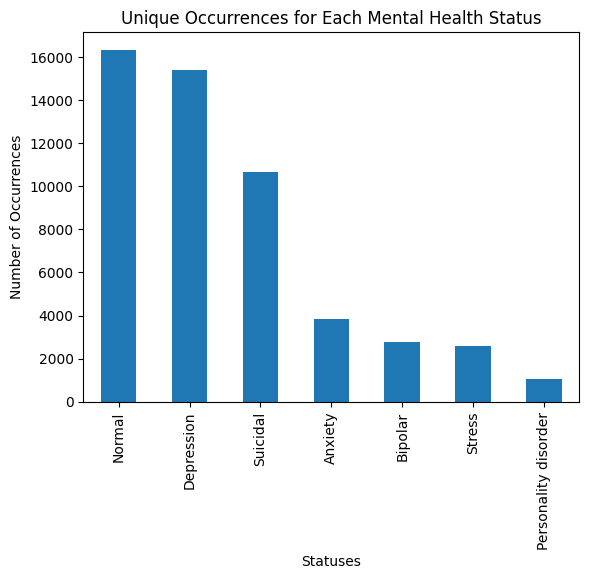

In [16]:
import matplotlib.pyplot as plt
# Let's create a bar chart showing the number of unique occurrences of each status, now that we have cleaned out null and/or empty entries.
# Collect the number of unique occurrences.
status_counts = dataset_clean['status'].value_counts()
# print(status_counts)

# Create the bar chart
status_counts.plot(kind='bar')
plt.xlabel('Statuses')
plt.ylabel('Number of Occurrences')
plt.title('Unique Occurrences for Each Mental Health Status')
plt.show()

In [17]:
# Let's encode all of the statuses so that our models can work with them for classification.
from sklearn.preprocessing import LabelEncoder
label_encode = LabelEncoder()

# Temporarily just make a new column for the encoded mental health status for easier viewing.
dataset_clean["encoded_status"] = label_encode.fit_transform(dataset_clean["status"])
dataset_clean.head()

,Unnamed: 0,statement,status,processed_statement,encoded_status
0,0,oh my gosh,Anxiety,oh my gosh,0
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,troubl sleep confus mind restless heart all ou...,0
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...,0
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shift my focu to someth els but im still w...,0
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless it been a month now b...,0


In [18]:
# Encoded classes?
statuses = label_encode.classes_ # the string names
statuses

array(['Anxiety', 'Bipolar', 'Depression', 'Normal',
       'Personality disorder', 'Stress', 'Suicidal'], dtype=object)

In [19]:


# Get unique status values
unique_status = dataset_clean['status'].unique()
unique_status

# Showing which integer values in encoded_status correspond with the string value in status
matching_values = dataset_clean[dataset_clean['status'].isin(unique_status)][['status', 'encoded_status']].drop_duplicates()

# Print the 'cupcake' values
print(matching_values)

                     status  encoded_status
0                   Anxiety               0
733                  Normal               3
6982             Depression               2
6985               Suicidal               6
27346                Stress               5
45394               Bipolar               1
50654  Personality disorder               4


In [20]:
# dataset_clean.head() # can I randomize the rows that come out to view different statuses more easily?
print(dataset_clean["statement"][22327])
print(dataset_clean["processed_statement"][22327]) # create a rule so that "standarts...Living" becomes "standarts living" instead of "standartsliving"? for row 22327
print(dataset_clean["status"][22327])
print(dataset_clean["encoded_status"][22327])

there were rules to which obeyed, standarts...Living in a charade thy was all. No real purpose can save you when you are mentally ill. I have OCD non responsive to meds. Everday I lose a part of my identity. Constant fight beetween two spheres of my brain. I was a star dust and I am ready and fulfilled in life to go back to where everthing started. I love my friend Yamur which is a mix of passion and love and charity. I can do anything for her if I had been healthy enough.I love my family too they matter a lot. But I can not tolerate my daily melancholic suicidal depression and obsessions just for the sake of them. The world has no rules on grand scale no justice no purpose. we have to distract our mind and create and illusion each second just to forget we exist. Yes we exist and this must be a bad joke. We are walking to the eventual death of us each day. Some of us only suffer while some of us can be happy in their distraction.For example the girl I loved we are texting only Ilove he

In [21]:
# Probably need to do some more preprocessing like removing stopwords and stemming/lemmatization but let's move on for now
# import nltk
# # import re
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer

# nltk.download('punkt')
# nltk.download('stopwords')

# def stemming(statement_text):


In [22]:
#Tokenization
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
# Split and train the data.
X = dataset_clean['processed_statement'] # feature
y = dataset_clean['encoded_status'] # target

print("X:", len(X), " y:", len(y)) # 52681 52681, both

X: 52681  y: 52681


In [24]:
# Split and train the data, split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # change random_state? no?

# Checking shape of training and test sets really quick
print("X train:", len(X_train), "y train:",  len(y_train)) # correct?
print("X test:", len(X_test), "y test:", len(y_test))  # correct?

X train: 42144 y train: 42144
X test: 10537 y test: 10537


In [25]:
# import nltk
# from nltk.stem import PorterStemmer

# nltk.download('punkt')

# # Initialize the stemmer (using Porter stemmer algorithm)
# stemmer = PorterStemmer()

# # custom tokenizer function to allow stemming integration into CountVectorizer
# def stemmed_tokenizer(statement_text):
#     # Tokenization
#     tokens = nltk.word_tokenize(statement_text)
#     # Stemming
#     stemmed_tokens = [stemmer.stem(token) for token in tokens]
#     return stemmed_tokens

In [26]:
#Tokenization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words = "english") # play with parameters later(?)
# vectorizer_stemming = CountVectorizer(stop_words = "english", tokenizer = stemmed_tokenizer) # good???

# Use CountVectorizer to transform our training data for features
X_vectorized_train = vectorizer.fit_transform(X_train)

# Use CountVectorizer to transform our testing data for features
X_vectorized_test = vectorizer.transform(X_test)

In [27]:
print(vectorizer.vocabulary_)
# print(vectorizer_stemming.vocabulary_)

{'know': 24546, 'like': 25685, 'stupid': 42489, 'reason': 36508, 'decid': 10322, 'mayb': 27337, 'right': 37521, 'time': 44941, 'thi': 44415, 'leap': 25179, 'just': 23916, 'feel': 15300, 'confirm': 8579, 'friend': 16462, 'celebr': 7026, 'togeth': 45298, 'famili': 14949, 'proud': 35440, 'sit': 40272, 'bedroom': 4359, 'alon': 1424, 'dad': 9749, 'gave': 17128, 'hug': 21025, 'wa': 48263, 'nice': 30394, 'better': 4721, 'moment': 28806, 'knowledg': 24570, 'thing': 44436, 'pretti': 35052, 'worthless': 49868, 'end': 13489, 'ha': 18459, 'kind': 24395, 'cement': 7050, 'idea': 21453, 'realli': 36457, 'worth': 49864, 'think': 44498, 'death': 10228, 'ani': 1993, 'differ': 11268, 'unacknowledg': 46551, 'mileston': 28274, 'life': 25509, 'endless': 13514, 'effort': 13060, 'push': 35732, 'forward': 16256, 'led': 25232, 'announc': 2061, 'semianonym': 39228, 'onlin': 31871, 'forum': 16253, 'sad': 38149, 'graduat': 17926, 'today': 45249, 'year': 50317, 'educ': 12998, 'drove': 12496, 'lowest': 26480, 'state

In [28]:
# Use the data we just prepared to fit and train a Dummy Classifier in order to obtain a common sense baseline, to be used to measure the models' performance.
from sklearn.dummy import DummyClassifier

dummy_baseline = DummyClassifier(strategy='stratified', random_state = 42) # random_state = 42 ? same as when using train_test_split on my models

dummy_baseline.fit(X_vectorized_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# Getting our common sense baseline from the Dummy Classifier
y_pred_baseline = dummy_baseline.predict(X_vectorized_test)
acc_baseline = accuracy_score(y_test, y_pred_baseline) # accuracy
f1_baseline = f1_score(y_test, y_pred_baseline, average="weighted") # f1 score, using average = 'weighted' because the target is multiclass
prec_baseline = precision_score(y_test, y_pred_baseline, average="weighted") # precision
recall_baseline = recall_score(y_test, y_pred_baseline, average="weighted") # recall

print("Dummy Classifier Baseline:\n")
print("Accuracy:", acc_baseline)
print("F1 Score:", f1_baseline)
print("Precision:", prec_baseline)
print("Recall:", recall_baseline)

Dummy Classifier Baseline:

Accuracy: 0.2346018790927209
F1 Score: 0.23484934694182893
Precision: 0.23513114743747132
Recall: 0.2346018790927209


In [30]:
# hyperparameter tuning with GridSearchCV here
from sklearn.model_selection import GridSearchCV
# https://scikit-learn.org/1.5/modules/naive_bayes.html#multinomial-naive-bayes
# alpha smoothing
# note the force-alpha parameter of MultinomialNB, which by default forces alpha to be 1e-10 if it is ever set to be less than that, so no point in going past that
# move this, put it before my original build of the Naive Bayes model(?)
nb_param_grid = {
  'alpha': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
}

# grid_scoring = ['accuracy', 'precision', 'recall', 'f1']
grid_scoring = 'accuracy'

nb_grid_cv = GridSearchCV(estimator = MultinomialNB(), param_grid = nb_param_grid, scoring = grid_scoring, verbose = 1, cv = 5) # n_jobs?
nb_grid_cv.fit(X_vectorized_train, y_train)
print(nb_grid_cv.best_estimator_)
print(nb_grid_cv.best_score_)
print(nb_grid_cv.best_params_) # 0.1 = 1e-1

Fitting 5 folds for each of 11 candidates, totalling 55 fits
MultinomialNB(alpha=0.1)
0.680001810820701
{'alpha': 0.1}


In [31]:
# Naive Bayes
# Build the Naive Bayes classifier.
# nb_model = MultinomialNB()
nb_model = MultinomialNB(alpha = 0.1)

# Fit the model using the training set we prepared.
nb_model.fit(X_vectorized_train, y_train)

MultinomialNB(alpha=0.1)

In [32]:
from sklearn.model_selection import StratifiedKFold

all_nb_acc = []
all_nb_f1 = []
all_nb_prec = []
all_nb_recall = []

k = 5
nb_skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

for (train_index, test_index) in nb_skf.split(X_vectorized_train, y_train):
  # print("Fold: " + (fold + 1))

  X_train_fold, X_test_fold = X_vectorized_train[train_index], X_vectorized_train[test_index]
  y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

  # Get a fresh model
  nb_model_fold = MultinomialNB(alpha = 0.1)

  # Train the model
  nb_model_fold.fit(X_train_fold, y_train_fold)

  # Predict on test set (?)
  y_pred = nb_model_fold.predict(X_test_fold)

  # Evaluate accuracy
  acc = accuracy_score(y_test_fold, y_pred)
  #
  f1_fold = f1_score(y_test_fold, y_pred, average="weighted") # f1 score, using average = 'weighted' because the target is multiclass
  prec_fold = precision_score(y_test_fold, y_pred, average="weighted") # precision
  recall_fold = recall_score(y_test_fold, y_pred, average="weighted") # recall
  #
  all_nb_acc.append(acc)
  all_nb_f1.append(f1_fold)
  all_nb_prec.append(prec_fold)
  all_nb_recall.append(recall_fold)
  # print("Fold " + (fold + 1) + " Accuracy: " + acc)

# Calculate and display averages
avg_acc_nb = np.mean(all_nb_acc)
avg_f1_nb = np.mean(all_nb_f1)
avg_prec_nb = np.mean(all_nb_prec)
avg_recall_nb = np.mean(all_nb_recall)
# std_acc_nb = np.std(all_nb_acc)
print("Average Accuracy of Naive Bayes Classifier: " + str(avg_acc_nb))
print("Average F1 Score of Naive Bayes Classifier: " + str(avg_f1_nb))
print("Average Precision of Naive Bayes Classifier: " + str(avg_prec_nb))
print("Average Recall of Naive Bayes Classifier: " + str(avg_recall_nb))
# print(f"Standard Deviation of Naive Bayes Classifier: {np.std(all_nb_acc):.4f}")

Average Accuracy of Naive Bayes Classifier: 0.6792664661513073
Average F1 Score of Naive Bayes Classifier: 0.6833733980727343
Average Precision of Naive Bayes Classifier: 0.6964204115159922
Average Recall of Naive Bayes Classifier: 0.6792664661513073


In [33]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import f1_score

y_pred = nb_model.predict(X_vectorized_test)
acc_nb = accuracy_score(y_test, y_pred)
f1_nb = f1_score(y_test, y_pred, average="weighted") # f1 score, using average = 'weighted' because the target is multiclass
prec_nb = precision_score(y_test, y_pred, average="weighted") # precision
recall_nb = recall_score(y_test, y_pred, average="weighted") # recall

print("Naive Bayes Classifier:\n")
print("Accuracy:", acc_nb)
print("F1 Score:", f1_nb)
print("Precision:", prec_nb)
print("Recall:", recall_nb)

Naive Bayes Classifier:

Accuracy: 0.6843503843598747
F1 Score: 0.6887144531276107
Precision: 0.7056141261479346
Recall: 0.6843503843598747


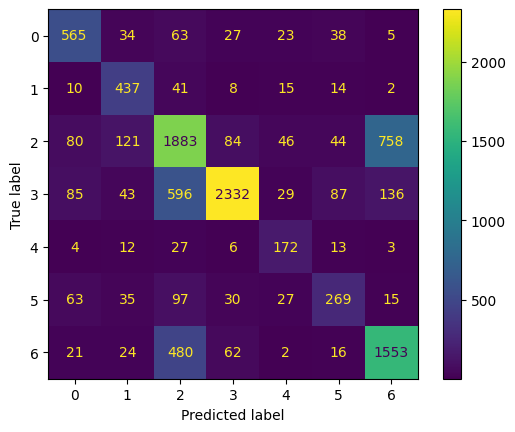

In [34]:
# Naive Bayes confusion matrix
from sklearn import metrics # repeat?
import matplotlib.pyplot as plt
# import seaborn as sns

matrix_labels = matching_values["encoded_status"] # need to fix!

nb_matrix = confusion_matrix(y_test, y_pred)

nb_matrix_plot = ConfusionMatrixDisplay(confusion_matrix = nb_matrix)

nb_matrix_plot.plot()
plt.show()

In [35]:
# # Example usage with Tokenizer:
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

from imblearn.over_sampling import RandomOverSampler

# Resampling (using RandomOverSampler) before tokenization, duplicating samples from minority classes to combat class imbalance found earlier
# oversample = RandomOverSampler(random_state = 42)
# Convert dataset_clean['processed_statement] to a 2D temporarily so that RandomOverSampler can work with it
# X_resampled, y_resampled = oversample.fit_resample(dataset_clean[['processed_statement']], dataset_clean['encoded_status']) # replace call to dataset_clean with X and y?

# Using [:, 0] to convert X_resampled back from the temporary 2D structure.
# X_resampled = X_resampled.squeeze()
# Convert resampled data back to a DataFrame for further working and tokenization.
# dataset_resampled = pd.DataFrame({'processed_statement': X_resampled, 'encoded_status': y_resampled})

# Tokenize the text
# vocab_size = 10000  # Adjust as needed
# tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # ran with this
tokenizer = Tokenizer(oov_token='<OOV>') # will run with this?
tokenizer.fit_on_texts(dataset_clean['processed_statement'])
# tokenizer.fit_on_texts(dataset_resampled['processed_statement'])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # ?
print("what is vocab_size?:", vocab_size)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(dataset_clean['processed_statement'])
# sequences = tokenizer.texts_to_sequences(dataset_resampled['processed_statement'])

# Pad sequences
max_length = 100  # Adjust as needed
padded_sequences = pad_sequences(sequences, maxlen = max_length, padding = 'post', truncating = 'post')

# Split data into training and testing sets
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(padded_sequences, dataset_clean['encoded_status'], test_size = 0.2, random_state = 42)
# X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(padded_sequences, dataset_resampled['encoded_status'], test_size = 0.2, random_state = 42)
# X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(padded_sequences, dataset_clean['status'], test_size = 0.2, random_state = 42)

# d. One-hot encode the target variable
y_train_rnn = tf.keras.utils.to_categorical(y_train_rnn, num_classes = 7) # I have 7 possible values for my target, so that's why this is 7
y_test_rnn = tf.keras.utils.to_categorical(y_test_rnn, num_classes = 7)

what is vocab_size?: 58873


In [36]:
# Recurrent Neural Network (RNN)
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

#
from keras.models import Model # delete in favor of import above? same?
from keras import layers
from keras import Input
# from keras.layers.merge import concatenate

# keep? play with?
max_features = 10000
maxlen = 500 # change?

# remove this later, keep now for reference and as a baseline for the RNN with submodels
def build_rnn_functional_api():
  inputs = Input(shape=(max_length,))  # used as argument for Model object

  # first argument is (max word index + 1), second argument is dimensionality of the embeddings (need to find that), from Listing 6.5 in book
  embedding_layer = layers.Embedding(vocab_size, 128)(inputs) # word embedding

  bidirectional_layer = layers.Bidirectional(layers.LSTM(64))(embedding_layer) # bidirectional RNN, defines the RNN

  # using 7 as the first argument because my target can have seven possible values
  outputs = layers.Dense(7, activation='softmax')(bidirectional_layer) # used as argument for Model object

  model = Model(inputs=inputs, outputs=outputs)  # Model object, uses inputs and outputs from before
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  print(model.summary()) # just a test, will run when function is called when model is built
  return model

# keep
def build_rnn_func_submodels():
  inputs = Input(shape=(max_length,))  # used as argument for Model object

  # first argument is (max word index + 1), second argument is dimensionality of the embeddings (need to find that), from Listing 6.5 in book
  embedding_layer = layers.Embedding(vocab_size, 128)(inputs) # word embedding

  # Recurrent dropout = 6.3.6 in book
  # gru_layer = layers.GRU(128, dropout = 0.2)(embedding_layer) # adding dropout to GRU layer
  # gru_layer = layers.GRU(128, dropout = 0.1)(embedding_layer) # adding dropout to GRU layer

  # trying this
  # dense_one = layers.Dense(128, activation='relu')(gru_layer)
  dense_one = layers.Dense(128, kernel_regularizer=regularizers.L2(0.001), activation='relu')(embedding_layer)

  # bidirectional_layer = layers.Bidirectional(layers.LSTM(64))(embedding_layer) # bidirectional RNN, defines the RNN

  # Layer Weight Sharing
  # have the submodels share the bidirectional layer?
  # bidirectional_layer_share = layers.Bidirectional(layers.LSTM(128)) # grabbed this from the first submodel

  # for submodel one
  # bidir_layer_one = bidirectional_layer_share(embedding_layer)

  ### first submodel
  # move embedding and bidirectional layers here later?
  # tracing back to the bidirectional layer we already have here for now
  # submodel_one = layers.Dense(64, activation='softmax')(bidirectional_layer) # 64? check
  # not yet in use, adapt rest of function
  # submodel_one = Model(inputs = inputs, outputs = bidirectional_layer) # using our bidirectional layer
  submodel_one = Model(inputs = inputs, outputs = dense_one) # using our gru layer
  # submodel_one = Model(inputs = inputs, outputs = bidir_layer_one) # using our bidirectional layer

  ### second submodel
  # need to build this one
  # inputs_two = Input(shape=(128, )) # max_length or 128 to match the bidirectional layer from before? check

  # Reshape the output of the first submodel to have a timestep dimension of 1
  # reshaped_features = layers.Reshape((1, 128))(features) # Reshape to (batch_size, 1, 128) (?)

  # inputs_two = Input(shape=(128, 1)) # Changed to 3D to include timesteps dimension. check
  inputs_two = Input(shape=(max_length, 128)) # Changed to 3D to include timesteps dimension. check
  # embedding_layer_b = layers.Embedding(vocab_size, 128)(inputs_b) # word embedding
  # bidirectional_layer = layers.Bidirectional(layers.LSTM(128))(inputs_two) # grabbed this from the first submodel
  bidirectional_layer = layers.Bidirectional(layers.LSTM(128, recurrent_dropout = 0.2))(inputs_two) # grabbed this from the first submodel
  # bidir_layer_two = bidirectional_layer_share(inputs_two) # grabbed this from the first submodel
  # bidir_layer_two = bidirectional_layer_share(reshaped_features) # grabbed this from the first submodel
  outputs_two = layers.Dense(7, kernel_regularizer=regularizers.L2(0.001), activation='softmax')(bidirectional_layer)
  submodel_two = Model(inputs = inputs_two, outputs = outputs_two)

  # using both submodels
  # combine_inputs = Input(
  combine_inputs = Input(shape=(max_length,)) # max_length change to hardcoded 128?
  features = submodel_one(combine_inputs)
  final_output = submodel_two(features)

  # using 7 as the first argument because my target can have seven possible values
  # outputs = layers.Dense(7, activation='softmax')(bidirectional_layer) # used as argument for Model object

  model = Model(inputs = combine_inputs, outputs = final_output)  # Model object, uses inputs and outputs from before
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Display some additional info about the model on execution.
  print(model.summary()) # just a test, will run when function is called when model is built
  return model

# remove this later, keep now for reference
def build_rnn():
  model = models.Sequential()
  # Add layers to model
  # model.add(layers.Embedding(max_features, 32)) # think I need to define max_features # other: word embedding?
  model.add(layers.Embedding(vocab_size, 128)) # first argument is (max word index + 1), second argument is dimensionality of the embeddings (need to find that), from Listing 6.5 in book
  model.add(layers.Bidirectional(layers.LSTM(64))) # defines the RNN

  # sigmoid good for binary classification problems, outputs a scalar (which is a one-dimensional vector), has a single unit
  # NOTE: this is not a binary classification problem, so switch to something other than sigmoid later
  # model.add(layers.Dense(1, activation = 'sigmoid')) # Third Layer
  # is softmax correct?
  # model.add(layers.Dense(1, activation = 'softmax')) # Third Layer
  # using 7 as the first argument because my target can have seven possible values
  model.add(layers.Dense(7, activation = 'softmax')) # Third Layer

  # model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model

In [37]:
# # Try it with the resampled set.
# rnn_model_func_api_smote = build_rnn_func_submodels()
# rnn_func_history_smote = rnn_model_func_api_smote.fit(X_resampled_train, y_resampled_train, epochs = 3, batch_size = 512, validation_split = 0.2)

In [38]:
# rnn_model = build_rnn()
# rnn_model_func_api = build_rnn_functional_api()
rnn_model_func_api = build_rnn_func_submodels()

import tensorflow as tf

# Reorder indices in X_vectorized_train BEFORE fitting the model
# X_vectorized_train = tf.sparse.reorder(X_vectorized_train) # keep?

# rnn_model.fit(X_vectorized_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2) # play with epochs and batch_size
# rnn_history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs = 10, batch_size = 512, validation_split = 0.2) # play with epochs and batch_size
# rnn_history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs = 3, batch_size = 512, validation_split = 0.2) # play with epochs and batch_size
# let's try changing 5 epochs to 3 for now since that's where it starts overfitting
# let's try 4 epochs now that regularisation seems to be helping
rnn_func_history = rnn_model_func_api.fit(X_train_rnn, y_train_rnn, epochs = 4, batch_size = 512, validation_split = 0.2) # play with epochs and batch_size

# notes on progress:
# changed to 3 epochs instead of the initial 10 to try and prevent overfitting to the training data (test_eval final accuracy was about 83% (?) with 10 epochs)
# test_eval final accuracy was about 70% (?) with 3 epochs
# going to try to go back to a larger number like 10 and try measures like Dropout layers

# trying to fix this:
# first go is not good, need to adjust parameters, this is the first run:
# accuracy: 0.0530 - loss: 0.0000e+00 - val_accuracy: 0.0542 - val_loss: 0.0000e+00

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 100, 128)            │       7,552,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,817,223 (29.82 MB)

 Trainable params: 7,817,223 (29.82 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.4763 - loss: 1.5719 - val_accuracy: 0.5578 - val_loss: 1.1951
Epoch 2/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.5815 - loss: 1.1043 - val_accuracy: 0.6355 - val_loss: 0.9434
Epoch 3/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.6585 - loss: 0.8671 - val_accuracy: 0.6889 - val_loss: 0.8453
Epoch 4/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.7401 - loss: 0.7152 - val_accuracy: 0.7219 - val_loss: 0.7801


In [39]:
# rnn_history_dict = rnn_history.history
# rnn_history_dict.keys()
rnn_func_history_dict = rnn_func_history.history
rnn_func_history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

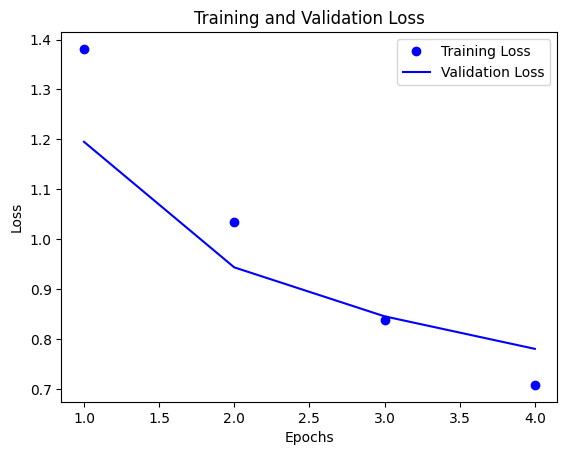

In [40]:
import matplotlib.pyplot as plt

def plot_loss(model_history): # change it up this time? no?
  loss = model_history['loss']
  val_loss = model_history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label = 'Training Loss')
  plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

# plot_loss(rnn_history_dict)
plot_loss(rnn_func_history_dict)
# seems to drop off at about epoch 3

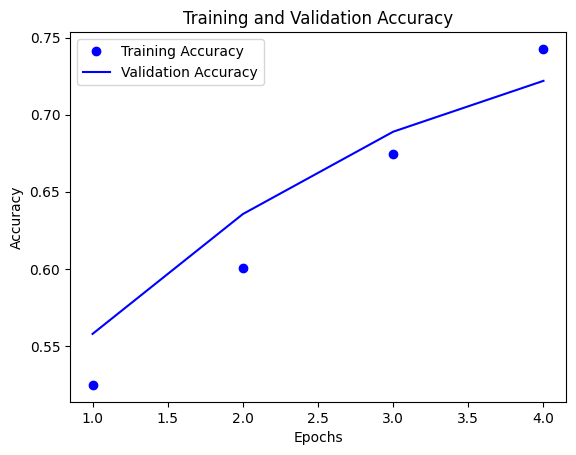

In [41]:
plt.clf() # clear the figure

def plot_accuracy(model_history):
  accuracy = model_history['accuracy']
  val_accuracy = model_history['val_accuracy']

  epochs = range(1, len(accuracy) + 1)

  plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
  plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

# plot_accuracy(rnn_history_dict)
plot_accuracy(rnn_func_history_dict)
# seems to drop off at about epoch 3

In [42]:
# # test_eval = rnn_model.evaluate(X_test_rnn, y_test_rnn) # output is [0.0, 0.05001423507928848]
# test_eval = rnn_model_func_api.evaluate(X_test_rnn, y_test_rnn) # output is [0.0, 0.05001423507928848]
# print("Test!:\n")
# print(test_eval)

In [43]:
# from sklearn.model_selection import StratifiedKFold
# from tensorflow.keras.utils import to_categorical
# import numpy as np

# Define k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

# To collect accuracy scores for each fold
all_fold_accuracies = []
all_fold_prec = []
all_fold_recall = []
all_fold_f1 = []

# for fold, (train_index, val_index) in enumerate(skf.split(X_train_rnn, np.argmax(y_train_rnn, axis=1))):
for (train_index, val_index) in skf.split(X_train_rnn, np.argmax(y_train_rnn, axis=1)):
  # print(f"Fold {fold + 1}/{k}")
  # print("Fold " + (fold + 1))

  # Get train and validation sets for the current fold
  X_train_fold, X_val_fold = X_train_rnn[train_index], X_train_rnn[val_index]
  y_train_fold, y_val_fold = y_train_rnn[train_index], y_train_rnn[val_index]

  # One-hot encode labels (if not already one-hot)
  # y_train_fold = to_categorical(y_train_fold, num_classes=7)
  # y_val_fold = to_categorical(y_val_fold, num_classes=7)

  # Rebuild model for each fold
  rnn_fold_model = build_rnn_func_submodels()

  # Train the model
  rnn_fold_model.fit(
      X_train_fold, y_train_fold,
      validation_data=(X_val_fold, y_val_fold),
      epochs = 4,
      batch_size = 512,
      verbose = 1
  )

  # Evaluate model on validation set
  # loss, accuracy = rnn_fold_model.evaluate(X_val_fold, y_val_fold, verbose=0)
  # all_fold_accuracies.append(accuracy)

  # predict probabilities for the validation set for this fold
  y_pred_fold = rnn_model_func_api.predict(X_val_fold, verbose = 0)
  # predict classes for the validation set for this fold
  y_pred_fold_classes = np.argmax(y_pred_fold, axis = 1)
  # Convert y_test_rnn to a multiclass format like y_pred_rnn_classes
  # to prevent a "multilabel-indicator and multiclass targets" error
  y_test_fold_classes = np.argmax(y_val_fold, axis=1) # Convert to the same format as y_pred_rnn_classes

  # Gather performance metrics for this fold, to be averaged later.
  acc = accuracy_score(y_test_fold_classes, y_pred_fold_classes)
  f1 = f1_score(y_test_fold_classes, y_pred_fold_classes, average = "weighted") # f1 score, using average = 'weighted' because the target is multiclass
  prec = precision_score(y_test_fold_classes, y_pred_fold_classes, average = "weighted", zero_division = np.nan) # precision
  recall = recall_score(y_test_fold_classes, y_pred_fold_classes, average = "weighted")
  all_fold_accuracies.append(acc)
  all_fold_prec.append(prec)
  all_fold_recall.append(recall)
  all_fold_f1.append(f1)
  # print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
  # print("Fold " + (fold + 1) + " Accuracy: " + accuracy)

# Compute final average accuracy
# final_avg_accuracy = np.mean(all_fold_accuracies)
# print(f"\nFinal Stratified K-Fold Validation Accuracy: {final_avg_accuracy:.4f}")
# print("\nAverage Accuracy for Recurrent Neural Network: " + final_avg_accuracy)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 100, 128)            │       7,552,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,817,223 (29.82 MB)

 Trainable params: 7,817,223 (29.82 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.4695 - loss: 1.5726 - val_accuracy: 0.5577 - val_loss: 1.1796
Epoch 2/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.5898 - loss: 1.0980 - val_accuracy: 0.6219 - val_loss: 0.9389
Epoch 3/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.6542 - loss: 0.8700 - val_accuracy: 0.6876 - val_loss: 0.8316
Epoch 4/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.7323 - loss: 0.7260 - val_accuracy: 0.7265 - val_loss: 0.7537


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 100, 128)            │       7,552,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_7 (Functional)            │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,817,223 (29.82 MB)

 Trainable params: 7,817,223 (29.82 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.4826 - loss: 1.5571 - val_accuracy: 0.5717 - val_loss: 1.1518
Epoch 2/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.5846 - loss: 1.0969 - val_accuracy: 0.6389 - val_loss: 0.9273
Epoch 3/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.6539 - loss: 0.8789 - val_accuracy: 0.6777 - val_loss: 0.8437
Epoch 4/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.7104 - loss: 0.7609 - val_accuracy: 0.7143 - val_loss: 0.7727


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_9 (Functional)            │ (None, 100, 128)            │       7,552,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_10 (Functional)           │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,817,223 (29.82 MB)

 Trainable params: 7,817,223 (29.82 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.4833 - loss: 1.5555 - val_accuracy: 0.5491 - val_loss: 1.2615
Epoch 2/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.5893 - loss: 1.0953 - val_accuracy: 0.6213 - val_loss: 0.9343
Epoch 3/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.6456 - loss: 0.8638 - val_accuracy: 0.6460 - val_loss: 0.8711
Epoch 4/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.6963 - loss: 0.7619 - val_accuracy: 0.6836 - val_loss: 0.8366


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_12 (Functional)           │ (None, 100, 128)            │       7,552,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_13 (Functional)           │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,817,223 (29.82 MB)

 Trainable params: 7,817,223 (29.82 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.4737 - loss: 1.5692 - val_accuracy: 0.5544 - val_loss: 1.1754
Epoch 2/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.5712 - loss: 1.1204 - val_accuracy: 0.6327 - val_loss: 0.9287
Epoch 3/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.6443 - loss: 0.8836 - val_accuracy: 0.6648 - val_loss: 0.8414
Epoch 4/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.7142 - loss: 0.7478 - val_accuracy: 0.7070 - val_loss: 0.7871


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_15 (Functional)           │ (None, 100, 128)            │       7,552,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_16 (Functional)           │ (None, 7)                   │         264,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,817,223 (29.82 MB)

 Trainable params: 7,817,223 (29.82 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.4858 - loss: 1.5661 - val_accuracy: 0.5659 - val_loss: 1.1679
Epoch 2/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.5789 - loss: 1.1066 - val_accuracy: 0.6376 - val_loss: 0.9265
Epoch 3/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.6602 - loss: 0.8547 - val_accuracy: 0.7021 - val_loss: 0.8059
Epoch 4/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.7348 - loss: 0.7177 - val_accuracy: 0.7285 - val_loss: 0.7608


In [44]:
# Compute final average accuracy
final_avg_accuracy = np.mean(all_fold_accuracies)
# print(f"\nFinal Stratified K-Fold Validation Accuracy: {final_avg_accuracy:.4f}")
print("Average Accuracy for Recurrent Neural Network: " + str(final_avg_accuracy))

# Compute final average metrics
final_avg_prec = np.mean(all_fold_prec)
final_avg_recall = np.mean(all_fold_recall)
final_avg_f1 = np.mean(all_fold_f1)
# print(f"\nFinal Stratified K-Fold Validation Accuracy: {final_avg_accuracy:.4f}")
print("Average Precision for Recurrent Neural Network: " + str(final_avg_prec))
print("Average Recall for Recurrent Neural Network: " + str(final_avg_recall))
print("Average F1 Score for Recurrent Neural Network: " + str(final_avg_f1))

Average Accuracy for Recurrent Neural Network: 0.7759112113393862
Average Precision for Recurrent Neural Network: 0.7719894032382985
Average Recall for Recurrent Neural Network: 0.7759112113393862
Average F1 Score for Recurrent Neural Network: 0.7657299969350179


In [45]:
# Final evaluation on testing set derived from split.
# test_eval = rnn_model.evaluate(X_test_rnn, y_test_rnn) # output is [0.0, 0.05001423507928848]
test_eval = rnn_model_func_api.evaluate(X_test_rnn, y_test_rnn)
print("Test!:\n")
print(test_eval)

330/330 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.7332 - loss: 0.7558
Test!:

[0.7524897456169128, 0.7324665188789368]


In [46]:
# predict probabilities for test set
y_pred_rnn = rnn_model_func_api.predict(X_test_rnn, verbose = 0)
# predict classes for test set
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis = 1)

# Take the above and turn them into 1D arrays instead of 2D so they work with the metric score calculation functions
# y_pred_rnn = y_pred_rnn[:, 0] # syntax? do i need to do this one since I only use y_pred_rnn_classes below?
# y_pred_rnn_classes = y_pred_rnn_classes[:, 0]

# Convert y_test_rnn to a multiclass format like y_pred_rnn_classes
# to prevent a "multilabel-indicator and multiclass targets" error
y_test_rnn_classes = np.argmax(y_test_rnn, axis=1) # Convert to the same format as y_pred_rnn_classes

acc_rnn = accuracy_score(y_test_rnn_classes, y_pred_rnn_classes)
f1_rnn = f1_score(y_test_rnn_classes, y_pred_rnn_classes, average="weighted") # f1 score, using average = 'weighted' because the target is multiclass
prec_rnn = precision_score(y_test_rnn_classes, y_pred_rnn_classes, average="weighted") # precision
recall_rnn = recall_score(y_test_rnn_classes, y_pred_rnn_classes, average="weighted") # recall

print("Recurrent Neural Network:\n")
print("Accuracy:", acc_rnn) # matches what test_eval got above, yay
print("F1 Score:", f1_rnn)
print("Precision:", prec_rnn)
print("Recall:", recall_rnn)

Recurrent Neural Network:

Accuracy: 0.7324665464553478
F1 Score: 0.7208801694364296
Precision: 0.7105435606408549
Recall: 0.7324665464553478


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

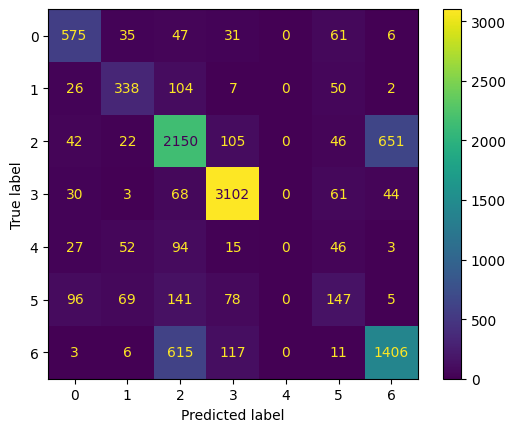

In [47]:
plt.clf()
rnn_matrix = confusion_matrix(y_test_rnn_classes, y_pred_rnn_classes)

rnn_matrix_plot = ConfusionMatrixDisplay(confusion_matrix = rnn_matrix)

rnn_matrix_plot.plot()

plt.show()

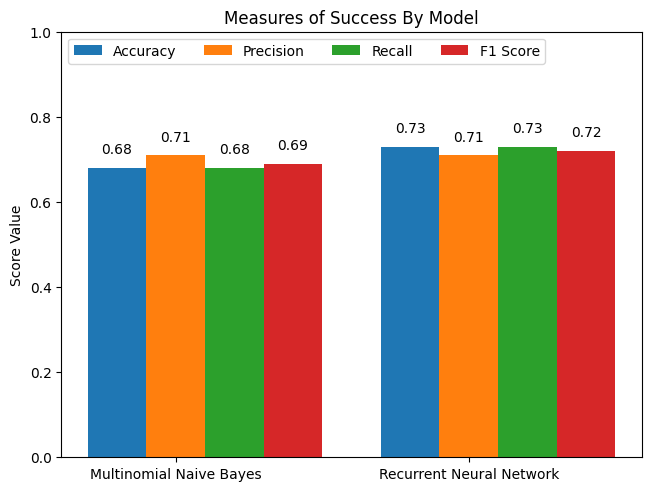

In [80]:
# Data visualisation for the performance of each model.
# print("Naive Bayes Classifier:\n")
# print("Accuracy:", acc_nb)
# print("F1 Score:", f1_nb)
# print("Precision:", prec_nb)
# print("Recall:", recall_nb)
model_types = ("Multinomial Naive Bayes", "Recurrent Neural Network")

# for the locations of the label on the chart
label_x = np.arange(len(model_types))
bar_width = 0.2
multiplier = 0 # change later?

measures = {
    "Accuracy": (round(acc_nb, 2), round(acc_rnn, 2)),
    "Precision": (round(prec_nb, 2), round(prec_rnn, 2)),
    "Recall": (round(recall_nb, 2), round(recall_rnn, 2)),
    "F1 Score": (round(f1_nb, 2), round(f1_rnn, 2))
}

fig, ax = plt.subplots(layout = "constrained")

for attribute, measurement in measures.items():
    offset = bar_width * multiplier
    rects = ax.bar(label_x + offset, measurement, bar_width, label = attribute)
    ax.bar_label(rects, padding = 8)
    multiplier += 1

ax.set_ylabel("Score Value")
ax.set_title("Measures of Success By Model")
ax.set_xticks(label_x + bar_width, model_types)
ax.legend(loc = "upper left", ncols = 4)
ax.set_ylim(0, 1)

plt.show()

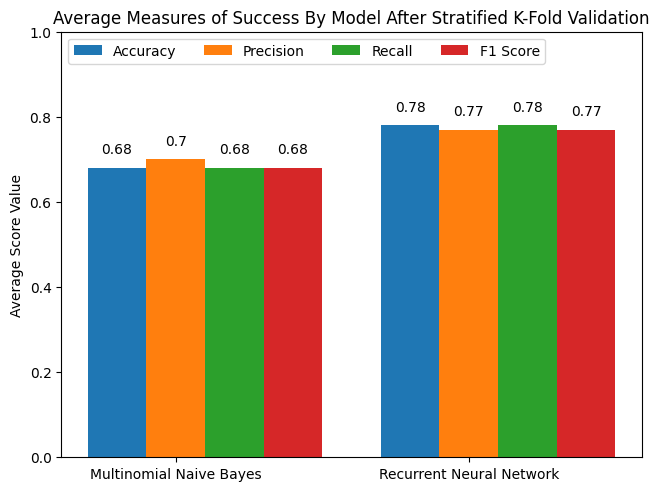

In [79]:
# Data visualisation for the performance of each model.
# print("Naive Bayes Classifier:\n")
# print("Accuracy:", acc_nb)
# print("F1 Score:", f1_nb)
# print("Precision:", prec_nb)
# print("Recall:", recall_nb)
# model_types = ("Multinomial Naive Bayes", "Recurrent Neural Network")

# for the locations of the label on the chart
label_x = np.arange(len(model_types))
bar_width = 0.2
multiplier = 0 # change later?

# print("Average Accuracy for Recurrent Neural Network: " + str(final_avg_accuracy))

# # Compute final average metrics
# final_avg_prec = np.mean(all_fold_prec)
# final_avg_recall = np.mean(all_fold_recall)
# final_avg_f1 = np.mean(all_fold_f1)


# print("Average Accuracy of Naive Bayes Classifier: " + str(avg_acc_nb))
# print("Average F1 Score of Naive Bayes Classifier: " + str(avg_f1_nb))
# print("Average Precision of Naive Bayes Classifier: " + str(avg_prec_nb))
# print("Average Recall of Naive Bayes Classifier: " + str(avg_recall_nb))

avg_measures = {
    "Accuracy": (round(avg_acc_nb, 2), round(final_avg_accuracy, 2)),
    "Precision": (round(avg_prec_nb, 2), round(final_avg_prec, 2)),
    "Recall": (round(avg_recall_nb, 2), round(final_avg_recall, 2)),
    "F1 Score": (round(avg_f1_nb, 2), round(final_avg_f1, 2))
}

fig, ax = plt.subplots(layout = "constrained")

for attribute, measurement in avg_measures.items():
    offset = bar_width * multiplier
    rects = ax.bar(label_x + offset, measurement, bar_width, label = attribute)
    ax.bar_label(rects, padding = 8)
    multiplier += 1

ax.set_ylabel("Average Score Value")
ax.set_title("Average Measures of Success By Model After Stratified K-Fold Validation")
ax.set_xticks(label_x + bar_width, model_types)
ax.legend(loc = "upper left", ncols = 4)
ax.set_ylim(0, 1)

plt.show()